In [8]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
np.random.seed(12)
no_obs = 5000

x1 = np.random.multivariate_normal([0,0],[[2, 0.75],[0.75, 2]], no_obs)
x2 = np.random.multivariate_normal([1,4],[[1, 0.75],[0.75, 1]], no_obs)
x3 = np.random.multivariate_normal([2,8],[[0, 0.75],[0.75, 0]], no_obs)

C:\Users\Ashish\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  


In [5]:
new_features = np.vstack((x1,x2,x3)).astype(np.float32)
new_labels = np.hstack((np.zeros(no_obs),
                       np.ones(no_obs),
                       np.ones(no_obs) + 1))

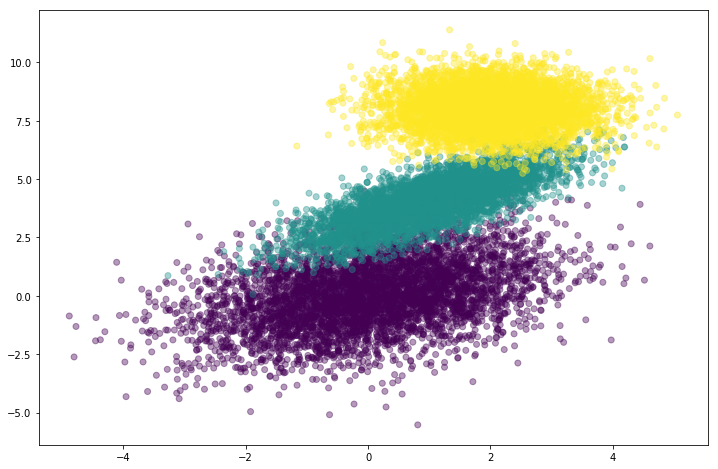

In [10]:
plt.figure(figsize=(12,8))
plt.scatter(new_features[:,0],
           new_features[:,1],
           c = new_labels,
           alpha = 0.4)

In [19]:
labels_onehot = np.zeros((new_labels.shape[0],3)).astype(int)
labels_onehot[np.arange(len(new_labels)), new_labels.astype(int)] = 1

array([    0,     1,     2, ..., 14997, 14998, 14999])

In [22]:
train_dataset, test_dataset,train_labels, test_labels = train_test_split(new_features, labels_onehot,
                test_size=0.1, random_state = 24)

In [45]:
train_df = train_dataset

hidden_nodes = 5
num_labels = train_labels.shape[1]
num_features = train_df.shape[1]
lr = 0.01
reg_lambda = 0.01

num_labels
num_features
train_df.shape

(13500, 2)

In [36]:
# weight and bias array

layer1_weights_array = np.random.normal(0, 1, [num_features, hidden_nodes]) 
layer2_weights_array = np.random.normal(0, 1, [hidden_nodes, num_labels]) 

layer1_biases_array = np.zeros((1, hidden_nodes))
layer2_biases_array = np.zeros((1, num_labels))

In [41]:
layer1_weights_array

array([[ 0.01866712,  2.60883056, -0.20027009, -0.37959022, -0.24099304],
       [ 1.21153698,  0.41787951, -1.87001576, -1.06484971,  0.47015637]])

In [42]:
def relu_activation(data_array):
    return np.maximum(data_array, 0)

def softmax(output_array):
    logits_exp = np.exp(output_array)
    return logits_exp / np.sum(logits_exp, axis = 1, keepdims = True)

def cross_entropy_softmax_loss_array(softmax_probs_array, y_onehot):
    indices = np.argmax(y_onehot, axis = 1).astype(int)
    predicted_probability = softmax_probs_array[np.arange(len(softmax_probs_array)), indices]
    log_preds = np.log(predicted_probability)
    loss = -1.0 * np.sum(log_preds) / len(log_preds)
    return loss

def regularization_L2_softmax_loss(reg_lambda, weight1, weight2):
    weight1_loss = 0.5 * reg_lambda * np.sum(weight1 * weight1)
    weight2_loss = 0.5 * reg_lambda * np.sum(weight2 * weight2)
    return weight1_loss + weight2_loss



In [50]:
for step in range(5001):
    input_layer = np.dot(train_df, layer1_weights_array) #13500 X 2 vs 2 X 5
    hidden_layer = relu_activation(input_layer + layer1_biases_array)
    output_layer = np.dot(hidden_layer, layer2_weights_array) + layer2_biases_array
    output_probs = softmax(output_layer)
    
    loss = cross_entropy_softmax_loss_array(output_probs, train_labels)
    loss += regularization_L2_softmax_loss(reg_lambda, layer1_weights_array, layer2_weights_array)
    
    output_error_signal = (output_probs - train_labels)/output_probs.shape[0]
    
    error_signal_hidden = np.dot(output_error_signal, layer2_weights_array.T)
    error_signal_hidden[hidden_layer <= 0] = 0
    
    gradient_layer2_wt = np.dot(hidden_layer.T, output_error_signal)
    gradient_layer2_bias = np.sum(output_error_signal, axis = 0, keepdims = True)
    
    gradient_layer1_wt = np.dot(train_df.T, error_signal_hidden)
    gradient_layer1_bias = np.sum(error_signal_hidden, axis = 0, keepdims = True)
    
    gradient_layer2_wt += reg_lambda * layer2_weights_array
    gradient_layer1_wt += reg_lambda * layer1_weights_array
    
    layer1_weights_array -= lr * gradient_layer1_wt
    layer1_biases_array -= lr * gradient_layer1_bias
    layer2_weights_array -= lr * gradient_layer2_wt
    layer2_biases_array -= lr * gradient_layer2_bias
    
    if step % 500 == 0:
        print(step, loss)



0 0.22718595191340013
500 0.22003595566326314
1000 0.21404554561476008
1500 0.20888969839677718
2000 0.204395763426881
2500 0.20040298883892366
3000 0.1967918000218798
3500 0.19360595306234268
4000 0.1907754617067598
4500 0.1880968625223784
5000 0.18558615336764872


In [53]:
def accuracy(predictions, labels):
    preds_correct_boolean =  np.argmax(predictions, 1) == np.argmax(labels, 1)
    correct_predictions = np.sum(preds_correct_boolean)
    accuracy = 100.0 * correct_predictions / predictions.shape[0]
    return accuracy

input_layer = np.dot(test_dataset, layer1_weights_array)
hidden_layer = relu_activation(input_layer + layer1_biases_array)
scores = np.dot(hidden_layer, layer2_weights_array) + layer2_biases_array
probs = softmax(scores)
print(accuracy(probs, test_labels))

95.4


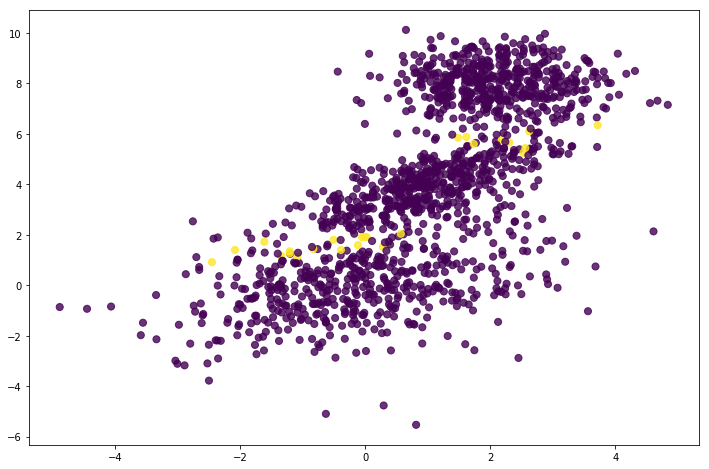

In [54]:
labels_flat = np.argmax(test_labels, axis = 1)
predictions = np.argmax(probs, axis=1)
plt.figure(figsize=(12,8))
plt.scatter(test_dataset[:,0],
           test_dataset[:,1],
           c = predictions == labels_flat-1,
           alpha = 0.8,
           s = 50)